
--- 1. Coletando dados da API... ---
  [OK] Dados para 2024-10-26 coletados. Taxa: 5.6739
  [OK] Dados para 2024-10-27 coletados. Taxa: 5.6739
  [OK] Dados para 2024-10-28 coletados. Taxa: 5.6896
  [OK] Dados para 2024-10-29 coletados. Taxa: 5.7187
  [OK] Dados para 2024-10-30 coletados. Taxa: 5.7849
  [OK] Dados para 2024-10-31 coletados. Taxa: 5.7558
  [OK] Dados para 2024-11-01 coletados. Taxa: 5.7706
  [OK] Dados para 2024-11-02 coletados. Taxa: 5.7706
  [OK] Dados para 2024-11-03 coletados. Taxa: 5.7706
  [OK] Dados para 2024-11-04 coletados. Taxa: 5.8092
  [OK] Dados para 2024-11-05 coletados. Taxa: 5.7850
  [OK] Dados para 2024-11-06 coletados. Taxa: 5.8090
  [OK] Dados para 2024-11-07 coletados. Taxa: 5.6549
  [OK] Dados para 2024-11-08 coletados. Taxa: 5.7588
  [OK] Dados para 2024-11-09 coletados. Taxa: 5.7588
  [OK] Dados para 2024-11-10 coletados. Taxa: 5.7588
  [OK] Dados para 2024-11-11 coletados. Taxa: 5.8095
  [OK] Dados para 2024-11-12 coletados. Taxa: 5.7578
  [OK] D

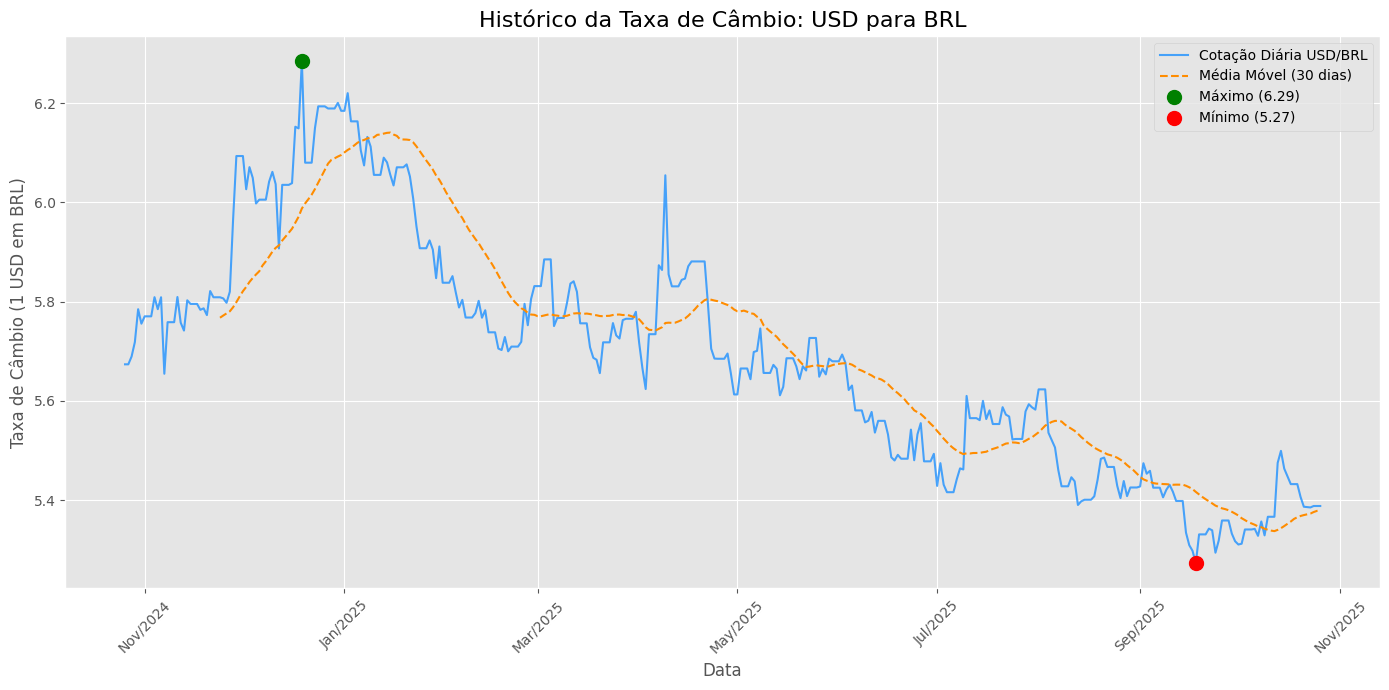


--- 5. Processo concluído. Arquivo CSV gerado. ---


In [1]:
import requests  
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ==============================================================================
#  CONFIGURAÇÃO INICIAL
# ==============================================================================

API_URL = "https://api.frankfurter.app"
CSV_NOME = 'cotacoes.csv'  
MOEDA_BASE = 'USD'
MOEDA_ALVO = 'BRL'

# Período de 1 ano de dados históricos
DATA_FIM = datetime.now()
DATA_INICIO = DATA_FIM - timedelta(days=365)


# ==============================================================================
#  COLETA DE DADOS VIA API E CRIAÇÃO DO DATAFRAME 
# ==============================================================================
print("\n--- 1. Coletando dados da API... ---") 

# Define o intervalo de datos que irá ser realizado a busca
datas_para_buscar = pd.date_range(start=DATA_INICIO, end=DATA_FIM, freq='D')

dados = [] 

for data in datas_para_buscar:
    data_str = data.strftime('%Y-%m-%d')
    
    # Url especifica para a API
    url_completa = f"{API_URL}/{data_str}?from={MOEDA_BASE}&to={MOEDA_ALVO}"
    
    try:
        # Requisição para a API
        response = requests.get(url_completa)
        response.raise_for_status()  # Lança um erro para respostas HTTP ruins (4xx ou 5xx)
        
        # Extrai os dados do JSON
        dados_api = response.json()
        taxa = dados_api['rates'][MOEDA_ALVO]
        
      
        # Adiciona os dados coletados à lista
        dados.append([data_str, MOEDA_BASE, MOEDA_ALVO, taxa])
        
        
        print(f"  [OK] Dados para {data_str} coletados. Taxa: {taxa:.4f}") 

    except requests.exceptions.RequestException as e:
        print(f"  [ERRO] Falha na requisição para {data_str}: {e}")
    except KeyError:
        # A API pode não ter dados para fins de semana ou feriados (Não esquecer)
        print(f"  [AVISO] Sem dados de câmbio para {data_str} (provavelmente fim de semana/feriado).")
    except Exception as e:
        print(f"  [ERRO] Ocorreu um erro inesperado para {data_str}: {e}")


print("[OK] Coleta de dados finalizada.")

# ==============================================================================
#  PROCESSAMENTO (CSV) E ANÁLISE DE DADOS COM PANDAS
# ==============================================================================
print("\n--- 2. Criando DataFrame e salvando em CSV... ---") 

# Cria DataFrame a partir da lista 'dados' 
df = pd.DataFrame(dados, columns=['data', 'moeda_base', 'moeda_alvo', 'taxa'])

# Salva em CSV                             
df.to_csv(CSV_NOME, index=False)
print(f"[OK] Arquivo {CSV_NOME} criado com sucesso!")


print("\n--- 3. Preparando dados e realizando a análise... ---") # <--- Título da seção atualizado



# Verifica se o DataFrame criado a partir da API não está vazio
if not df.empty:
    
 
    
    # 1. Converter a coluna 'data' de texto para o tipo datetime
    df['data'] = pd.to_datetime(df['data'])
    
    # 2. Definir a coluna 'data' como o índice do DataFrame
    df = df.set_index('data')
    
    
    
    print("\nAnálise Descritiva da Taxa de Câmbio:")
    print(df['taxa'].describe())

    
    valor_maximo = df['taxa'].max()
    data_maximo = df['taxa'].idxmax().strftime('%d/%m/%Y')
    valor_minimo = df['taxa'].min()
    data_minimo = df['taxa'].idxmin().strftime('%d/%m/%Y')
    
    print(f"\n- Maior cotação: {valor_maximo:.4f} em {data_maximo}")
    print(f"- Menor cotação: {valor_minimo:.4f} em {data_minimo}")

   

    df['media_movel_30d'] = df['taxa'].rolling(window=30).mean()
    
    print("[OK] Análise concluída.")
    
    # ==============================================================================
    #  VISUALIZAÇÃO DOS DADOS 
    # ==============================================================================
    print("\n--- 4. Gerando visualização gráfica... ---")

    plt.style.use('ggplot') 
    fig, ax = plt.subplots(figsize=(14, 7)) # figura e os eixos do gráfico

    # Plota a taxa de câmbio diária
    ax.plot(df.index, df['taxa'], label=f'Cotação Diária {MOEDA_BASE}/{MOEDA_ALVO}', color='dodgerblue', alpha=0.8)
    
    # Plota a média móvel
    ax.plot(df.index, df['media_movel_30d'], label='Média Móvel (30 dias)', color='darkorange', linestyle='--')
    
    # Adiciona marcadores para os pontos de máximo e mínimo
    ax.plot(df['taxa'].idxmax(), valor_maximo, 'go', markersize=10, label=f'Máximo ({valor_maximo:.2f})')
    ax.plot(df['taxa'].idxmin(), valor_minimo, 'ro', markersize=10, label=f'Mínimo ({valor_minimo:.2f})')

    # Configurações do gráfico para melhor visualização
    ax.set_title(f'Histórico da Taxa de Câmbio: {MOEDA_BASE} para {MOEDA_ALVO}', fontsize=16)
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel(f'Taxa de Câmbio (1 {MOEDA_BASE} em {MOEDA_ALVO})', fontsize=12)
    ax.legend(fontsize=10)
    
    # Formatação do eixo de datas para ficar mais legível
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    plt.xticks(rotation=45)
    
    plt.tight_layout() 
    plt.show()

else:
    print("\n[AVISO] Nenhum dado foi encontrado no banco de dados para gerar a análise e o gráfico.")

# ==============================================================================
# 5. ENCERRAMENTO 
# ==============================================================================
print("\n--- 5. Processo concluído. Arquivo CSV gerado. ---") # <--- Print atualizado